# 單元 07-1. Autoencoder and Variational Autoencoder

本單元，我們將帶領各位實作非監督式學習中相當重要的神經網路模型及其變形。

## 1. 初始準備

In [30]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Activation, Lambda, concatenate
from keras.optimizers import SGD

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

讀取 MNIST 手寫辨識資料

In [33]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [34]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

x_train = x_train/255
x_test = x_test/255

## 2. Autoencoder

Autoencoder，又稱為自編碼器，是一個將資料壓縮再還原的模型，是由一編碼器與一解碼器所結合而成的函數。

用數學符號表示，這個模型可以寫成：

$$ \mathbb{R}^n \overset{Encoder}{\to} \mathbb{R}^m \overset{Decoder}{\to} \mathbb{R}^n$$

$$ x \overset{Encoder}{\mapsto} h \overset{Decoder}{\mapsto} \hat{x} $$

其中，$m<n$，且 $x\approx\hat{x} = Decoder(h) = Decoder\big(Encoder(x)\big)$，其中，$h$ 被稱之為 latent 變數，或稱 $x$ 的 latent 表示。

換言之，我們希望原本的資料 $x$，經過函數 $Encoder$ (編碼器) 編碼成維度比較小的資料 $h$，再透過函數 $Decoder$ (解碼器)，還原成 $\hat{x}$。

其中，$m<n$ 代表的是，資料編碼後所剩的資訊是能用於還原的重要資訊/特徵，而 $x\approx\hat{x}$ 代表可還原資料。

一般而言，我們會希望 $Encoder$ 和 $Decoder$ 看起來有點對稱。

### 2.1 Autoencoder 與手寫辨識資料 MNIST

在這裡，我們考慮使用 Autoencoder 模型壓縮並還原 MNIST 手寫辨識資料。

因此， $n=28x28=784$，且我們希望壓縮後的維度為 $2$，且隱藏層的神經元數量為 100。

本單元所建構的的 Autoencoder 結構如下:

<img src="autoencoder.png" alt="drawing" style="width: 400px;"/>

In [35]:
enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid') ## activation 使用 sigmoid，就能將 $h$ 限制在 $[0, 1]\times[0, 1]$ 之間

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

接著，定義層前後變數之間的關係；首先，第一個變數必定以 `Input` 函數來定義

In [36]:
x = Input(shape=(784,))

$$x \to enc~x \to h \to dec~x \to \hat{x}$$

In [37]:
enc_x = enc_1(x)
h = enc_2(enc_x)

dec_x = dec_2(h)
x_reconstructed = dec_1(dec_x)

In [38]:
autoencoder = Model(x, x_reconstructed)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_12 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_13 (Dense)             (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


一樣的，當模型 compile 之後，便可以進行資料的訓練、預測等等，請有興趣的同學讀入 MNIST 手寫辨識之料後，自行完成這個模型的訓練。

In [39]:
autoencoder.compile(loss='kullback_leibler_divergence', optimizer='Nadam')

In [11]:
autoencoder.fit(x_train, x_train, batch_size=32, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 6s 96us/step - loss: -21.3069
Epoch 2/100
60000/60000 [==============================] - 5s 87us/step - loss: -22.0461
Epoch 3/100
60000/60000 [==============================] - 5s 89us/step - loss: -22.0490
Epoch 4/100
60000/60000 [==============================] - 5s 87us/step - loss: -22.0497
Epoch 5/100
60000/60000 [==============================] - 5s 85us/step - loss: -22.0499
Epoch 6/100
60000/60000 [==============================] - 5s 87us/step - loss: -22.0500
Epoch 7/100
60000/60000 [==============================] - 5s 86us/step - loss: -22.0500
Epoch 8/100
60000/60000 [==============================] - 5s 86us/step - loss: -22.0500
Epoch 9/100
60000/60000 [==============================] - 5s 88us/step - loss: -22.0500
Epoch 10/100
60000/60000 [==============================] - 5s 87us/step - loss: -22.0500
Epoch 11/100
60000/60000 [==============================] - 5s 87us/step - loss: -22.0500
Epoch 12/100
60000/

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



如果覺得訓練太久的話，也可以使用我們準備好的權重。

In [40]:
autoencoder.load_weights('autoencoder_handwriting_model_weights.h5')

### 2.2 視覺化 - 子模型的取出
為了視覺化(及其他潛在應用)，我們也會從 Autoencoder 將 Encoder 和 Decoder 分別定義出來。

$$\mbox{Autoencoder:}~x \to enc~x \to h \to dec~x \to \hat{x}$$
$$\mbox{Encoder:}~x \to enc~x \to h $$
$$\mbox{Decoder:}~h \to dec~x \to \hat{x}$$

In [41]:
Encoder = Model(x, h)

Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


由於 Decoder 是從 $h$ 往後兩層，因此，我們需要先定義一個同樣大小的 `Input`。

In [42]:
h_input = Input(shape=(2,))

Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_13 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


### 2.3 視覺化 - Encoder
在建構 Autoencoder 時，我們設定 $h$ 的維度為 $2$ 是為了視覺化上的呈現，本小節將介紹如何操作神經網路來視覺化手寫辨識資料 MNIST。

首先，我們隨便抽取一張圖，並透過 Encoder 來算出它的 latent 表示。

====== 練習 =====

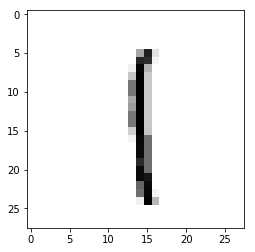

In [64]:
n = 203

plt.imshow(x_test[n].reshape(28,28), cmap='Greys')

In [65]:
E = Encoder.predict(np.array([x_test[n]]))

In [66]:
Y = Decoder.predict(E)

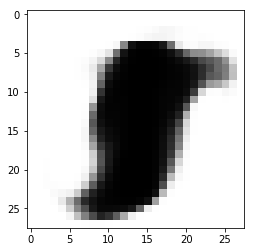

In [67]:
plt.imshow(Y.reshape(28,28), cmap='Greys')

==== 練習結束 ==== 

In [68]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 59484 圖的 latent 表示為 [[0.12900195 0.99911827]]


接者，我們從 $10000$ 筆測試資料隨機挑選 $1000$ 手寫辨識資料，將其轉換成 latent 表示法，並畫在同一平面上。

In [69]:
idices = np.random.randint(x_test.shape[0], size=1000)

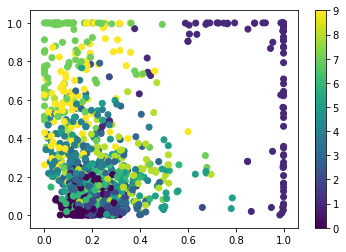

In [70]:
latents = Encoder.predict(x_test[idices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test[idices])
plt.colorbar()
plt.show()

### 2.4 視覺化 - Decoder

首先，我們在 $[0, 1]\times[0, 1]$ 這個單位正方形內均勻取樣 $15*15$ 個點，並將這 $225$ 個平面上的點，透過 Decoder 進行圖片的還原。

In [71]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [72]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

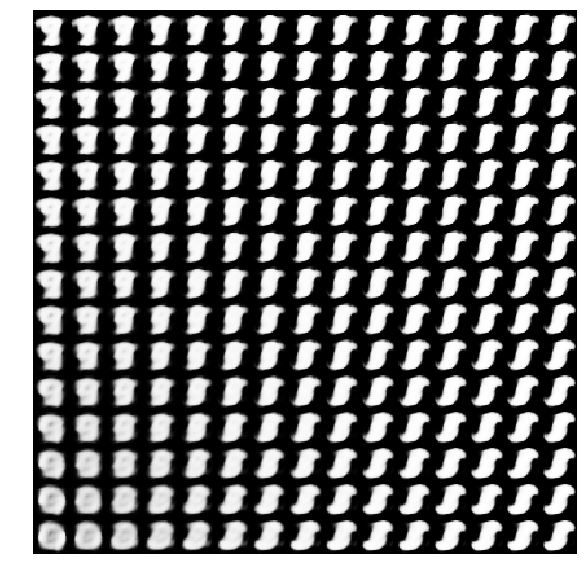

In [73]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## 3 Variational Autoencoder
Autoencoder 是將每筆資料壓縮成 latent 表示後再進行還原。

以手寫辨識資料 MNIST 為例，由於壓縮的方式是確定的，因此，每張手寫圖片的 latent 表示是固定的。

換句話說，Autoencoder 只是一種將資料(以其 latent)適當的擺放的函數。

如果每筆資料的 latent 不僅僅是一個固定的位置，而是希望在這個 latent 附近，都能和還原的差不多，那我們應該怎麼做呢？

在此，我們將介紹 Variational Autoencder，一種當代知名的自編碼器，就具有上述的效果。

本節我們準備建構的 Variational Autoencoder 的結構如下：

<img src="variational_autoencoder.png" alt="drawing" style="width: 400px;"/>

在此， Encoder 的作用不是將資料表示成 latent，而是將資料表示成常態分配的兩個參數，平均數與變異數。

而 Decoder 也不再直接使用 Encoder 的結果，而是將 Encoder 的結果作為常態抽樣的兩個參數來進行。

因此，資料經過 Encoder，會得到一適當大小的常態分配之參數，而 Decoder 則使用這組參數進行抽樣。

即使是同一筆資料，Decoder 每次接受到的 latent 表示法可能都不一樣 (但會在某個平均數附近)。

### 3.2 VAE 的建立
為了避免混淆，我們重新定義所有變數，首先，我們定義 Encoder 上的三個神經網路層

In [214]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [215]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [216]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [217]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [218]:
dec_x = dec_2(z)
x_reconstructed = dec_1(dec_x)

In [219]:
VAE = Model(x, x_reconstructed)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 100)          78500       input_7[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 2)            202         dense_19[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 2)            202         dense_19[0][0]                   
__________________________________________________________________________________________________
lambda_3 (

### 3.3 Loss 函數的建立
VAE 的 loss 函數，其由來牽扯一些訊息理論 (information theory) 的知識，因此，我們在此直接建立訓練 VAE 時的 loss 函數。

若對 VAE 的理論及模型基本設定有興趣的同學，可以參考下列兩篇論文：
* Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
* Tutorial on Variational Autoencoders: https://arxiv.org/pdf/1606.05908.pdf

In [220]:
from keras import metrics

In [221]:
def vae_loss(x, x_recon):  
    
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    return recovery_loss + kl_loss

### 3.4 訓練 VAE

In [222]:
VAE.compile(loss=vae_loss, optimizer='Nadam')

In [ ]:
VAE.fit(x_train, x_train, batch_size=32, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 7s 113us/step - loss: 188.0429
Epoch 2/100
60000/60000 [==============================] - 7s 108us/step - loss: 177.7603
Epoch 3/100
60000/60000 [==============================] - 6s 108us/step - loss: 170.9927
Epoch 4/100
60000/60000 [==============================] - 6s 107us/step - loss: 166.2744
Epoch 5/100
60000/60000 [==============================] - 6s 106us/step - loss: 163.3919
Epoch 6/100
60000/60000 [==============================] - 6s 104us/step - loss: 161.0345
Epoch 7/100
60000/60000 [==============================] - 7s 109us/step - loss: 159.0652
Epoch 8/100
60000/60000 [==============================] - 6s 107us/step - loss: 157.3742
Epoch 9/100
60000/60000 [==============================] - 6s 107us/step - loss: 155.9724
Epoch 10/100
60000/60000 [==============================] - 6s 108us/step - loss: 154.8801
Epoch 11/100
60000/60000 [==============================] - 7s 110us/step - loss: 153.9495
Epoch 12

In [223]:
# VAE.save_weights('VAE_handwriting_model_weights.h5')
VAE.load_weights('VAE_handwriting_model_weights.h5')

### 3.5 VAE 的視覺化呈現
與視覺化 Autoencoder 時的方式一樣，我們先分別定義出 Encoder 和 Decoder。

$$\mbox{VAE:}~x\to enc~x\to (\mu, \log\sigma^2)\to z \to dec~x\to \hat{x}$$
$$\mbox{Encoder:}~x\to enc~x\to \mu$$
$$\mbox{Decoder:}~z \to dec~x\to \hat{x}$$

In [224]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [225]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_23 (Dense)             (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


=== 練習 ===

In [226]:
data8 = np.arange(10000)[y_test==8]
data7 = np.arange(10000)[y_test==7]

In [227]:
data8

array([  61,   84,  110,  128,  134,  146,  177,  179,  181,  184,  226,
        232,  233,  242,  257,  260,  266,  268,  277,  290,  299,  338,
        344,  355,  373,  374,  391,  401,  403,  429,  431,  435,  436,
        458,  465,  466,  470,  474,  486,  495,  520,  527,  538,  542,
        543,  553,  563,  572,  580,  582,  591,  596,  601,  603,  606,
        621,  631,  641,  655,  664,  685,  691,  693,  709,  714,  718,
        761,  781,  787,  793,  800,  805,  806,  839,  844,  864,  872,
        876,  877,  878,  879,  899,  914,  915,  936,  947,  961,  983,
        998, 1007, 1018, 1026, 1029, 1033, 1052, 1068, 1074, 1093, 1101,
       1118, 1120, 1124, 1125, 1149, 1170, 1185, 1198, 1200, 1202, 1219,
       1225, 1229, 1234, 1248, 1249, 1259, 1267, 1268, 1286, 1287, 1312,
       1319, 1320, 1324, 1325, 1353, 1364, 1371, 1389, 1394, 1398, 1415,
       1425, 1433, 1441, 1443, 1464, 1470, 1474, 1499, 1502, 1523, 1524,
       1530, 1541, 1556, 1560, 1562, 1567, 1568, 15

In [186]:
np.random.choice(data8)

2152

In [196]:
np.random.choice(data7)

9314

In [228]:
n = 9314

E = VAE_Encoder.predict(np.array([x_test[n]]))

In [229]:
E

array([[-2.0755317,  1.5307862]], dtype=float32)

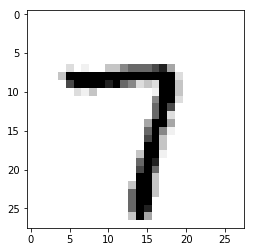

In [231]:
plt.imshow(x_test[n].reshape(28,28),cmap="Greys")

In [232]:
Y = VAE_Decoder.predict(E)

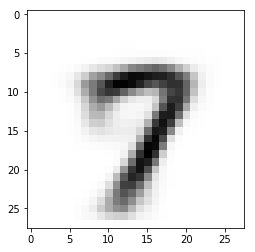

In [234]:
plt.imshow(Y.reshape(28,28), cmap='Greys')

In [235]:
E8 = VAE_Encoder.predict(np.array([x_test[2152]]))
E7 = VAE_Encoder.predict(np.array([x_test[9314]]))

In [236]:
d = (E7 - E8)[0]

In [237]:
delta = d/100

In [238]:
from ipywidgets import interact

In [212]:
def me87(k=0):
    E = E8 + k*delta
    Y = VAE_Decoder.predict(E)
    plt.imshow(Y.reshape(28,28), cmap='Greys')

In [239]:
interact(me87, k=(0,100))

interactive(children=(IntSlider(value=0, description='k'), Output()), _dom_classes=('widget-interact',))

<function __main__.me87(k=0)>

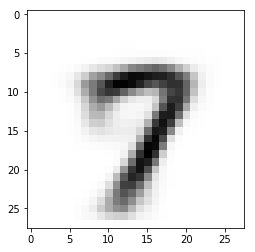

In [201]:
plt.imshow(Y.reshape(28,28),cmap='Greys')

In [146]:
E

array([[-2.6857195,  1.7989048]], dtype=float32)

In [141]:
Y2 = VAE_Decoder.predict(E + np.array([0.01,0.01]))

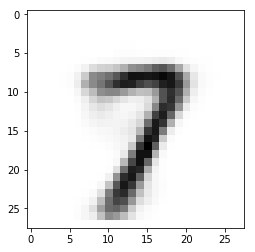

In [142]:
plt.imshow(Y2.reshape(28,28), cmap='Greys')

首先，我們進行 Encoder 的視覺化呈現。

In [240]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 28407 圖的 latent 表示為 [[-0.89861643 -1.0366248 ]]


In [241]:
# idices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[idices])

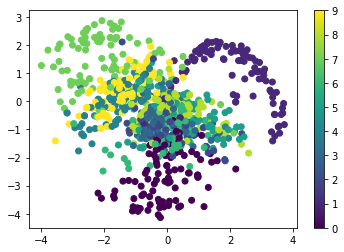

In [242]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[idices])
plt.colorbar()
plt.show()

接著，我們進行 Decoder 的視覺化呈現。

In [243]:
n=10

def normalize_to_unit(x):
    x -= x.min()
    x /= x.max()
    return x

In [244]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalize_to_unit(digit)

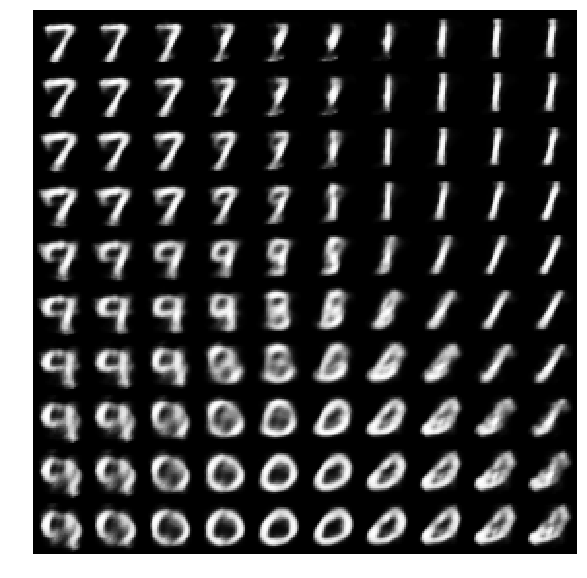

In [245]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys_r')
plt.axis('off')
plt.show()

### 3.6 與 Autoencoder 的 Encoder 視覺化進行比較

In [ ]:
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test[idices])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test[idices])
plt.colorbar()
plt.show()

## 4. 恭喜你，完成學習並建立 Variational Autoencoder 及神經網路的基本視覺化呈現。

Variational Autoencoder (VAE) 是一個重要的非監督式學習模型，具體應用的場合為特徵抽取/資料壓縮及還原，為影像處理中常見的模型之一。

恭喜各位已經完成了學習，在本單元的練習中，我們希望各位嘗試建立並訓練屬於自己的 VAE。